In [8]:
%load_ext autoreload
%autoreload 2

from typing import List
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, auc, accuracy_score, balanced_accuracy_score

from hnlp_proj.loader import load_ynet, load_eng_test
from hnlp_proj.processing import Processing, process_data
from hnlp_proj.utils import extract_authors, flip_hebrew_text, combine_texts, clean_texts
from hnlp_proj.plot_utils import plot_hebrew_barchart, plot_corpus_sizes, plot_feature_freqs
from hnlp_proj.delta import DeltaTransformer, combine_texts_by_author


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
texts = load_ynet(show_html_len_plot=False)
#texts = load_eng_test()


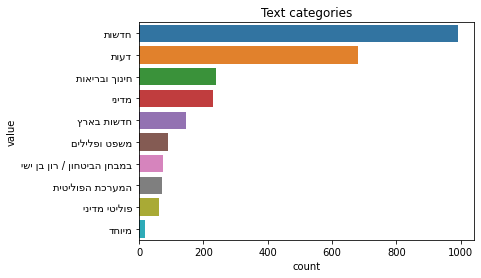

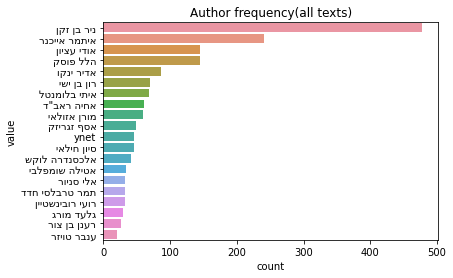

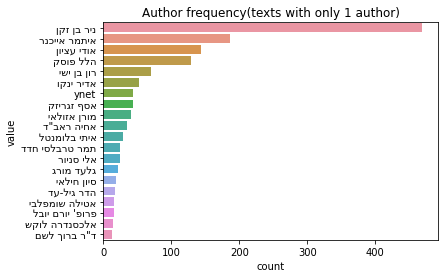

In [74]:
# Plotting frequency of categories
if "category" in texts.columns:
    plot_hebrew_barchart(texts.category, 20, title="Text categories")

# Plotting author frequency of texts
NUM_AUTHORS = 20
texts.authors = texts.authors.apply(extract_authors)
plot_hebrew_barchart(texts.authors, NUM_AUTHORS, title="Author frequency(all texts)")

# find all texts that only have 1 author
one_author_df = texts[texts.authors.str.len() == 1].copy()
one_author_df["authors"]  = one_author_df["authors"].apply(lambda ls: ls[0])
one_author_df.rename(columns={"authors": "author"}, inplace=True)

if len(one_author_df) != len(texts):
    plot_hebrew_barchart(one_author_df.author, NUM_AUTHORS, title="Author frequency(texts with only 1 author)")

In [5]:
print(f"Out of {len(texts)} articles, {len(one_author_df)} of them were written by exactly 1 author")

Out of 2607 articles, 1900 of them were written by exactly 1 author


In [6]:
# find texts with no author(Faulty parsing?)
no_author_df = texts[texts.authors.str.len() == 0]
no_author_df

,fmt,url,main_title,sub_title,authors,date,text,category
14,2021,https://www.ynet.co.il/news/article/SkvJP7fH00,"בלי להודיע: ארה""ב העבירה לפחות 75 מיליון דולר ...","על פי דיווח בסוכנות הידיעות AP, ממשל ביידן איש...",[],"31.03.21 , 20:57",ארצות הברית אישרה בימים האחרונים העברת עשרות מ...,מדיני
28,2021,https://www.ynet.co.il/news/article/SyorLaZO00,"אופטימיות בגוש השינוי, סיכומים ראשונים על חלוק...",בסיומו של היום הראשון למנדט של לפיד נרשמת שביע...,[],"07.05.21 , 00:27",בקרב השותפים הפוטנציאליים לממשלת השינוי נרשמה ...,המערכת הפוליטית
57,2021,https://www.ynet.co.il/news/article/r1sjt9J00u,גורמים בימין: נתניהו והרב טאו סיכמו להגביל עלי...,"הבוקר ב""ידיעות אחרונות"": עד לאחרונה התנגד נחרצ...",[],"05.05.21 , 07:15",גורמים בקרב פעילי הר הבית טוענים כי של לאשר ממ...,המערכת הפוליטית
89,2021,https://www.ynet.co.il/news/article/Bk5VPxfNd,דיווח: ראש המוסד התערב להסרת המגבלות על מיליאר...,יוסי כהן והשגריר לשעבר דרמר שכנעו את ממשל טראמ...,[],"19.03.21 , 12:42","למהלך השנוי במחלוקת והחשאי ל , בשלהי ימי ממשל ...",מדיני
92,2021,https://www.ynet.co.il/news/article/BkK1s1Z400,"אזהרה ישראלית בביקור בצרפת: ""לא נהסס לתקוף בעו...","הרמטכ""ל כוכבי אמר כי ""לבנון הפכה שבויה בידי חי...",[],"18.03.21 , 18:02","נשיא המדינה , שמבקר בפריז שבצרפת עם הרמטכ""ל , ...",מדיני
...,...,...,...,...,...,...,...,...
2602,2021,https://www.ynet.co.il/news/article/BkhnD9QGd,לא לשפוך את התינוק עם המים של טראמפ,"ביידן מתרחק מכל מה שקשור בנשיא הקודם, כולל המד...",[],"24.02.21 , 12:00",קולו של חבר הקונגרס הדמוקרטי ג’יימי רסקין נשבר...,דעות
2603,2021,https://www.ynet.co.il/news/article/BktSK5mz00,הפגם לא מתחיל בתיקי נתניהו ולא נגמר שם,"משפטני-על, שמצופה מהם שדבר לא ייפול מידיהם, לא...",[],"24.02.21 , 12:01","""נפל פגם"", במשפטו של ראש הממשלה בנימין נתניהו....",דעות
2604,2021,https://www.ynet.co.il/news/article/rymTSuQMd,אתם לא בוחרים שלטון. אתם אוהדי כדורגל,"בחירה פוליטית היא חלק מהזהות, כמו סגנון לבוש א...",[],"24.02.21 , 08:51","תארו לעצמכם שביום הבחירות הגעתם לקלפי, הצגתם א...",דעות
2605,2021,https://www.ynet.co.il/news/article/S1kZ2FMM00,מתווה ההשתקה שעקף את משפחות ילדי תימן,"ה""הסכם"" לפיצוי משפחות ילדי תימן, מזרח והבלקן פ...",[],"23.02.21 , 16:14","לפני ארבע שנים בדיוק זכיתי לתעד את מפתח תקווה,...",דעות


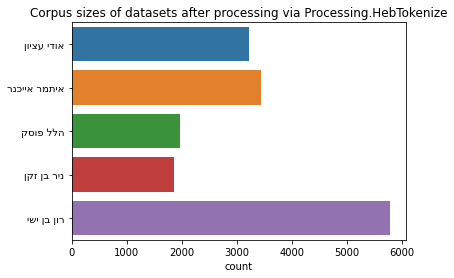

combine by author


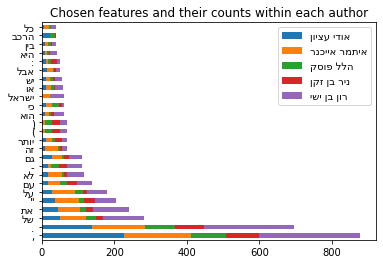

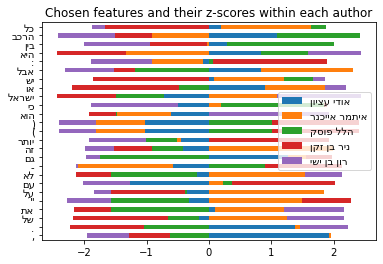

In [108]:


RANDOM_STATE = 0
NUM_AUTHORS = 5
NUM_FEATURES = 25
MAX_TEXTS_PER_AUTHOR = 5
PROCESSING = Processing.HebTokenize

# choose some of the most prolific authors
most_prolific_authors = one_author_df.author.value_counts()[:NUM_AUTHORS].index
used_texts = one_author_df.set_index("author").loc[most_prolific_authors].reset_index()
used_texts = used_texts.groupby("author").head(MAX_TEXTS_PER_AUTHOR)

plot_corpus_sizes(combine_texts_by_author(process_data(used_texts, PROCESSING)), f"Corpus sizes of datasets after processing via {PROCESSING}")

# choose features
pipeline = make_pipeline(DeltaTransformer(num_features=NUM_FEATURES, processing=PROCESSING))
X = pipeline.fit_transform(used_texts, used_texts.index)
features = pipeline.steps[0][1].get_params()["features"]
counts = pipeline.steps[0][1].last_transformed_count
plot_feature_freqs(counts, title="Chosen features and their counts within each author")

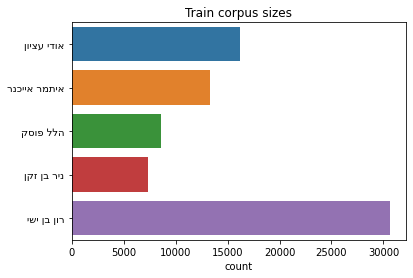

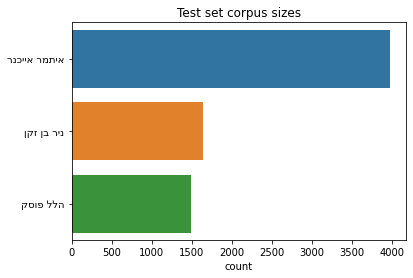

NameError: name 'create_feature_matrix' is not defined

In [39]:
# split one-author dataset to train and test
X_train, X_test = train_test_split(used_texts, random_state=RANDOM_STATE,
 test_size=0.1)

plot_corpus_sizes(combine_texts_by_author(X_train), title="Train corpus sizes")
plot_corpus_sizes(X_test.set_index("author"), "Test set corpus sizes")


X_train = create_feature_matrix(X_train, features=features)
X_test = create_feature_matrix(X_test, features=features, combine_by_author=False)
#X_train.dropna(inplace=True)
y_train = X_train.index
y_test = X_test.index


knn = KNeighborsClassifier(n_neighbors=1, metric="manhattan")
knn.fit(X_train, y_train)


y_pred = knn.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred, labels=most_prolific_authors, average='weighted')}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)}")
knn.score(X_test, y_test)

In [105]:
counts.sum(axis='columns')

author
אודי עציון       761
איתמר אייכנר     893
הלל פוסק         444
ניר בן זקן       443
רון בן ישי      1262
dtype: int64